# Scikit-learn tutorial: Predictive Analytics with Python

The Python programming language is a great option for data science and predictive analytics, as it comes equipped with multiple packages which cover most of your data analysis needs. For machine learning in Python, Scikit-learn (sklearn) is a great option and is built on NumPy, SciPy, and matplotlib (N-dimensional arrays, scientific computing, and data visualization respectively). 

## Part 1: Predicting MLB Team Wins per Season

In this tutorial, we’ll test out several machine learning models from sklearn to predict the number of games that a Major League Baseball team will win in a season. If I were a gambling man ([and I most certainly am a gambling man]( http://www.sharpdata.co/online-poker-pro-to-data-science-jedi-master/)), I could build a model using historic data from previous seasons to forecast the upcoming one.  Given the time series nature of the data, we could generate indicators such as average wins per year over the previous five years to make a highly accurate model. That is outside the scope of this tutorial, however and we will treat each row as independent.   Each row of our data will consist of a single team for a specific year.   The columns contain data related to that team and year:

*  `yearID` - Year
*  `teamID` - Team
*  `franchID` - Franchise (links to TeamsFranchise table)
*  `G` - Games played
*  `W` - Wins
*  `LgWin` - League Champion(Y or N)
*  `WSWin` - World Series Winner (Y or N)
*  `R` - Runs scored
*  `AB` - At bats
*  `H` - Hits by batters
*  `HR` - Homeruns by batters
*  `BB` - Walks by batters
*  `SO` - Strikeouts by batters
*  `SB` - Stolen bases
*  `CS` - Caught stealing
*  `HBP` - Batters hit by pitch
*  `SF` - Sacrifice flies
*  `RA` - Opponents runs scored
*  `ER` - Earned runs allowed
*  `ERA` - Earned run average
*  `CG` - Complete games
*  `SHO` - Shutouts
*  `SV` - Saves
*  `IPOuts` - Outs Pitched (innings pitched x 3)
*  `HA` - Hits allowed
*  `HRA` - Homeruns allowed
*  `BBA` - Walks allowed
*  `SOA` - Strikeouts by pitchers
*  `E` - Errors
*  `DP` - Double Plays
*  `FP` - Fielding  percentage
*  `name` - Team's full name


The full data set originally came from [Sean Lahman's site](http://www.seanlahman.com/baseball-archive/statistics/) and was transformed to a [sqlite database here](https://github.com/jknecht/baseball-archive-sqlite).

### Importing Data

We will read in our data by querying a sqlite database using the `sqlite3` package and converting to a dataframe with `pandas`.  Our data will be filtered to only include currently active modern teams and only years where the team played 150 or more games.

First, download the file "lahman2016.sqlite" ([download here](https://github.com/jknecht/baseball-archive-sqlite/blob/master/lahman2016.sqlite)).  Load `Pandas` and `sqlite3` and connect to the 

In [213]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [214]:
# Querying Database for all seasons where a team played 150 or more games and is still active today.  Creating dataframe from query.
query = '''select * from Teams 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == "Y";
'''
Teams = conn.execute(query).fetchall()
teams_df = pd.DataFrame(Teams)
print(teams_df.head())

     0   1    2    3     4   5    6     7   8   9   ...        42   43   44  \
0  1961  AL  LAA  ANA  None   8  162  82.0  70  91  ...    603510  111  112   
1  1962  AL  LAA  ANA  None   3  162  81.0  86  76  ...   1144063   97   97   
2  1963  AL  LAA  ANA  None   9  161  81.0  70  91  ...    821015   94   94   
3  1964  AL  LAA  ANA  None   5  162  81.0  82  80  ...    760439   90   90   
4  1965  AL  CAL  ANA  None   7  162  80.0  75  87  ...    566727   97   98   

    45   46   47   48                             49  50    51  
0  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
1  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
2  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
3  LAA  LAA  LAA  ANA  Los Angeles Angels of Anaheim   Y  None  
4  CAL  CAL  CAL  ANA  Los Angeles Angels of Anaheim   Y  None  

[5 rows x 52 columns]


### Cleaning and Preparing our Data

In [215]:
print(len(teams_df))

2287


In [216]:
# Adding column names to dataframe
cols = ["yearID","lgID","teamID","franchID","divID","Rank","G","Ghome","W",
"L","DivWin","WCWin","LgWin","WSWin","R","AB","H","2B","3B","HR","BB","SO","SB",
"CS","HBP","SF","RA","ER","ERA","CG","SHO","SV","IPouts","HA","HRA","BBA",
"SOA","E","DP","FP","name","park","attendance","BPF","PPF","teamIDBR","teamIDlahman45",
"teamIDretro ","franchID","franchName","active","NAassoc "
]
teams_df.columns = cols
print(teams_df.head())

   yearID lgID teamID  franchID divID  Rank    G  Ghome   W   L    ...     \
0    1961   AL    LAA       ANA  None     8  162   82.0  70  91    ...      
1    1962   AL    LAA       ANA  None     3  162   81.0  86  76    ...      
2    1963   AL    LAA       ANA  None     9  161   81.0  70  91    ...      
3    1964   AL    LAA       ANA  None     5  162   81.0  82  80    ...      
4    1965   AL    CAL       ANA  None     7  162   80.0  75  87    ...      

  attendance  BPF  PPF teamIDBR  teamIDlahman45  teamIDretro   franchID  \
0     603510  111  112      LAA             LAA           LAA       ANA   
1    1144063   97   97      LAA             LAA           LAA       ANA   
2     821015   94   94      LAA             LAA           LAA       ANA   
3     760439   90   90      LAA             LAA           LAA       ANA   
4     566727   97   98      CAL             CAL           CAL       ANA   

                      franchName  active  NAassoc   
0  Los Angeles Angels of Anaheim 

In [217]:
# Counting and displaying null values
df = teams_df[["yearID","teamID","G","W","R","AB","H","2B","3B","HR","BB","SO","SB","RA","ER","ERA","CG",
"SHO","SV","IPouts","HA","HRA","BBA","SOA","E","DP","FP"]]
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0]


In [218]:
# Eliminating rows with null values
df = df.dropna()
print(len(df))

2155


### Exploring and Visualizing Our Data

(array([  12.,   30.,  102.,  251.,  407.,  478.,  485.,  305.,   76.,    9.]),
 array([  36.,   44.,   52.,   60.,   68.,   76.,   84.,   92.,  100.,
         108.,  116.]),
 <a list of 10 Patch objects>)

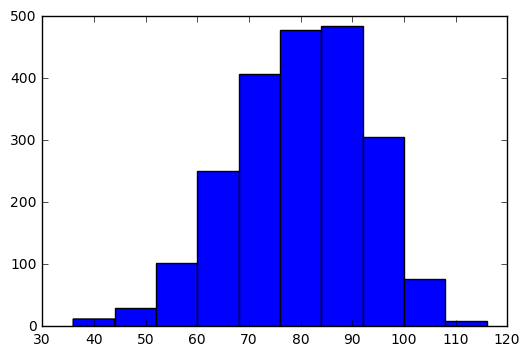

In [219]:
# Plotting distribution of wins
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df["W"])

In [220]:
# Creating bins for the win column
def assign_win_bins(W):
    if W < 40:
        return 0
    if W >= 40 and W <= 49:
        return 1
    if W >= 50 and W <= 59:
        return 2
    if W >= 60 and W <= 69:
        return 3
    if W >= 70 and W <= 79:
        return 4
    if W >= 80 and W <= 89:
        return 5
    if W >= 90 and W <= 99:
        return 6
    if W >= 100 and W <= 109:
        return 7
    if W >= 110 and W <= 119:
        return 8
    
df["win_bins"] = df["W"].apply(assign_win_bins)

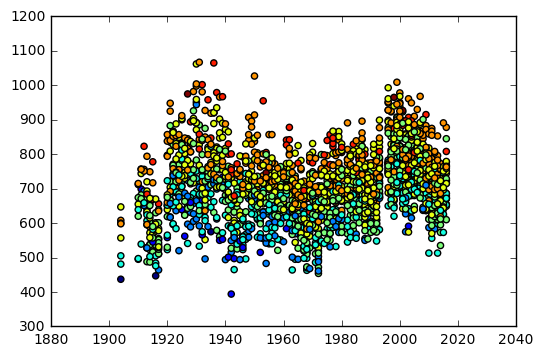

In [221]:
plt.scatter(df["yearID"], df["R"], c=df["win_bins"])

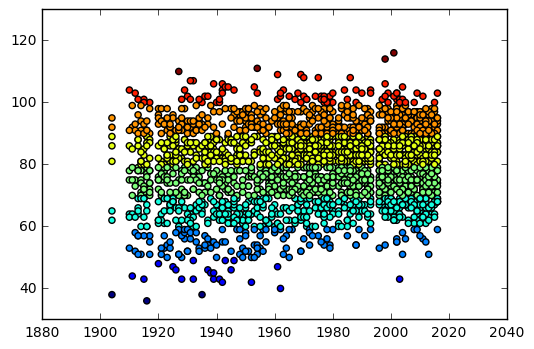

In [222]:
plt.scatter(df["yearID"], df["W"], c=df["win_bins"])

In [223]:
df = df[df["yearID"] > 1905]

### Adding New Features

In [224]:
# Creating "year_label" column, which will give our algorithm information about how certain years are related (Dead ball eras, Live ball/Steroid Eras)

def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8
    
df["year_label"] = df["yearID"].apply(assign_label)
dummy_df = pd.get_dummies(df["year_label"], prefix="era")
df = pd.concat([df, dummy_df], axis=1)

In [225]:
# Converting years into decade bins and creating dummy variables
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010
    
df["decade_label"] = df["yearID"].apply(assign_decade)
decade_df = pd.get_dummies(df["decade_label"], prefix="decade")
df = pd.concat([df, decade_df], axis=1)

In [226]:
df = df.drop(["yearID","year_label","decade_label"], axis=1)

In [227]:
# Creating new features for Runs per Game and Runs Allowed per Game
df["R_per_game"] = df["R"] / df["G"]
df["RA_per_game"] = df["RA"] / df["G"]

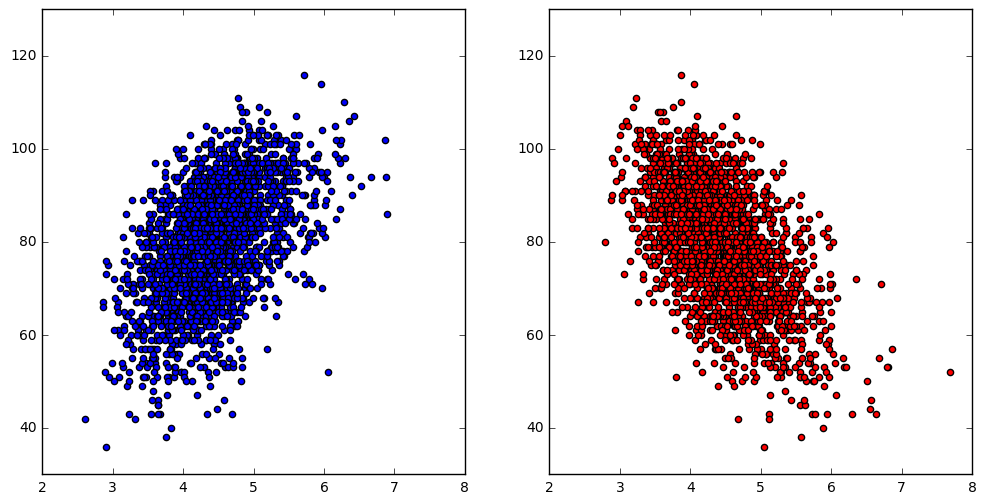

In [249]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(df["R_per_game"], df["W"], c="blue")
ax2.scatter(df["RA_per_game"], df["W"], c="red")
plt.show()

In [228]:
print(df.columns)

Index(['teamID', 'G', 'W', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB',
       'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA',
       'SOA', 'E', 'DP', 'FP', 'win_bins', 'era_1', 'era_2', 'era_3', 'era_4',
       'era_5', 'era_6', 'era_7', 'era_8', 'decade_1910', 'decade_1920',
       'decade_1930', 'decade_1940', 'decade_1950', 'decade_1960',
       'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000',
       'decade_2010', 'R_per_game', 'RA_per_game'],
      dtype='object')


In [229]:
df.corr()["W"]

G              0.176993
W              1.000000
R              0.547042
AB             0.243271
H              0.374653
2B             0.246455
3B             0.011668
HR             0.332152
BB             0.347757
SO             0.077403
SB             0.146808
RA            -0.544575
ER            -0.434657
ERA           -0.485965
CG            -0.013659
SHO            0.446973
SV             0.399833
IPouts         0.324340
HA            -0.421309
HRA           -0.016633
BBA           -0.322156
SOA            0.256120
E             -0.312019
DP            -0.020038
FP             0.328143
win_bins       0.975598
era_1         -0.053280
era_2         -0.094188
era_3         -0.037311
era_4         -0.060738
era_5          0.038795
era_6          0.055326
era_7          0.062907
era_8          0.041299
decade_1910   -0.053280
decade_1920   -0.062268
decade_1930   -0.059220
decade_1940   -0.057036
decade_1950   -0.054159
decade_1960    0.025737
decade_1970    0.030559
decade_1980    0

In [230]:
numeric_cols = ["G","R","AB","H","2B","3B","HR","BB","SO","SB","RA","ER","ERA","CG",
"SHO","SV","IPouts","HA","HRA","BBA","SOA","E","DP","FP","era_1","era_2","era_3","era_4","era_5","era_6","era_7","era_8","decade_1910","decade_1920","decade_1930","decade_1940","decade_1950","decade_1960","decade_1970","decade_1980",
"decade_1990","decade_2000","decade_2010","R_per_game","RA_per_game","W"]

In [231]:
data = df[numeric_cols]

In [232]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10, random_state=1)
distances = kmeans_model.fit_transform(data)

In [233]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data)
    s_s = metrics.silhouette_score(data, l)
    s_score_dict[i] = [s_s]
print(s_score_dict)

{2: [0.40250885707144213], 3: [0.26274056203780854], 4: [0.23672347641606081], 5: [0.22020510768838036], 6: [0.19724477310811536], 7: [0.19098373493975818], 8: [0.18323496865642855], 9: [0.1718561072420603], 10: [0.16477605607814252]}


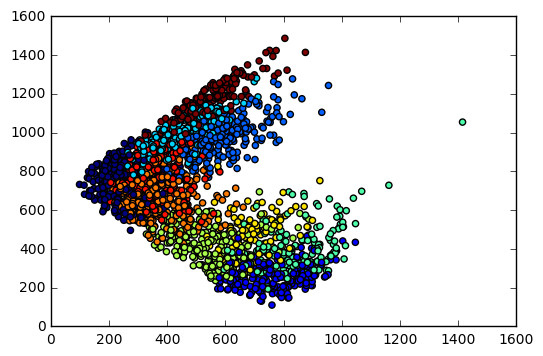

In [234]:
labels = kmeans_model.labels_
plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.show()

In [237]:
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data_df.index.isin(train.index)]

In [238]:
attributes = ["G","R","AB","H","2B","3B","HR","BB","SO","SB","RA","ER","ERA","CG",
"SHO","SV","IPouts","HA","HRA","BBA","SOA","E","DP","FP","era_1","era_2","era_3","era_4","era_5","era_6","era_7","era_8",
"decade_1910","decade_1920","decade_1930","decade_1940","decade_1950","decade_1960","decade_1970","decade_1980",
"decade_1990","decade_2000","decade_2010","R_per_game","RA_per_game"]

### Selecting Error Metric

In [235]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [239]:
lr = LinearRegression()
lr.fit(train[attributes], train["W"])
predictions = lr.predict(test[attributes])

In [240]:
mae = mean_absolute_error(test["W"], predictions)
print(mae)

2.68365642171


In [212]:
from sklearn.linear_model import Ridge
rrm = Ridge(alpha = .001)
rrm.fit(train[attributes], train["W"])
predictions_rrm = rrm.predict(test[attributes])
mae_rrm = mean_absolute_error(test["W"], predictions_rrm)
print(mae_rrm)

2.68122402578


## Part II: Predicting Hall of Fame Careers

In [241]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryBatting = 'select * from Batting;'
queryPitching = 'select * from Pitching;'
queryFielding = 'select * from Fielding;'
queryHOF = 'select playerID,yearid from HallofFame where inducted == "Y" and category == "Player";'

In [242]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
batting = conn.execute(queryBatting).fetchall()
batting_df = pd.DataFrame(batting)
pitching = conn.execute(queryPitching).fetchall()
pitching_df = pd.DataFrame(pitching)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)